#  Image Segmentation

### Import modules

In [2]:
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt

import time

import pandas as pd
# General
from glob import glob
import resource
from tqdm.notebook import tqdm

# Data Handling
import numpy as np
import pandas as pd
import json

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## Data loader 

In [3]:
info_df = pd.read_csv('data/HuBMAP-20-dataset_information.csv')

In [4]:
train_df = pd.read_csv('data/train.csv')

# Unroll encoding column
temp_df = pd.DataFrame(columns=['id', 'start', 'run'])
for i, [image_id, encoding] in train_df.iterrows():
    new_section = pd.DataFrame(columns=temp_df.columns)
    encoding = encoding.split()
    
    start = encoding[::2]
    run = encoding[1::2]
    encoding = np.array(list(zip(start, run))).astype(int)
    
    new_section['start'] = encoding[:,0]
    new_section['run'] = encoding[:,1]
    new_section['id'] = image_id
    
    temp_df = temp_df.append(new_section)
train_df = temp_df

In [5]:
IMG_SIZE = 256
BATCH_SIZE = 64

In [6]:
def _parse_image_function(example):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }

    features = tf.io.parse_single_example(example, image_feature_description)
    image = tf.image.decode_jpeg(features['image'], channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    mask = tf.image.decode_jpeg(features['mask'], channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    return image, mask

In [32]:
def read_dataset(file_list, batch_size, repeat=True):
    
    dataset = tf.data.TFRecordDataset(file_list)
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda x, y: (x/255, y/255))

    dataset = dataset.shuffle(500)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [8]:
ids_list = np.unique([path.split('/')[-1].split('_')[0] for path in glob('data/tf_records/*')])

In [9]:
np.random.seed(42)
test_ids = np.random.choice(ids_list, 2)
test_ids

array(['8242609fa', '26dc41664'], dtype='<U9')

In [10]:
train_files = []
test_files = []
for path in glob('data/tf_records/*'):

    is_test = False
    for test_id in test_ids:
        if test_id in path:
            test_files.append(path)
            
            is_test = True
            break
            
    if not is_test:
        train_files.append(path)

In [33]:
train = read_dataset(train_files, BATCH_SIZE)
test = read_dataset(test_files, BATCH_SIZE, repeat=False)

2021-12-29 18:05:40.369269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


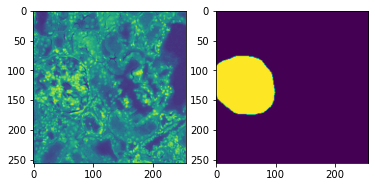

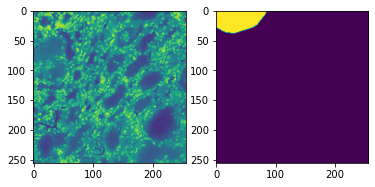

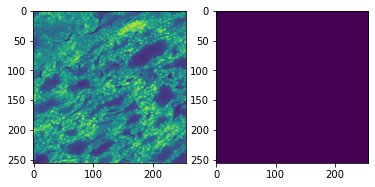

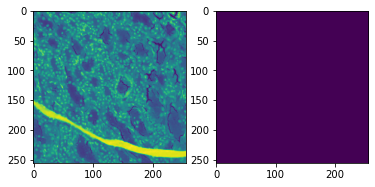

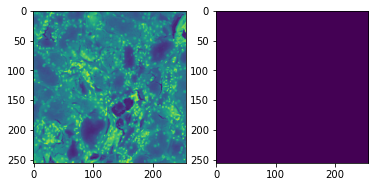

In [12]:
for b in train.take(1):
    
    masks = b[1]
    images = b[0]
    count = 0
    for image, mask in zip(images, masks):
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.show()
        count += 1
        if count == 5:
            break
    

## Define the model

In [13]:
OUTPUT_CHANNELS = 0

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [16]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
#         downsample(512, 4),  # (bs, 8, 8, 512)
#         downsample(512, 4),  # (bs, 4, 4, 512)
#         downsample(512, 4),  # (bs, 2, 2, 512)
#         downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
#         upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
#         upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
#         upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
#         upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='sigmoid')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [18]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

## Train the model

In [19]:
def generate_images(input_image, mask):    

    pred = generator.predict(input_image.copy()[np.newaxis, ...]).reshape(256,256, 1)
    
    print(dice_coef(pred, mask))

    # Plot
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.imshow(input_image[:,:,:3])

    plt.subplot(2, 2, 2)
    plt.imshow(mask)

    plt.subplot(2, 2, 3)
    plt.imshow(input_image[:,:,3])

    plt.subplot(2, 2, 4)
    plt.imshow(pred)

    plt.show()
    
    return input_image, mask

In [20]:
def dice_coef(a, b, smooth=1e-5):
    
    sum_a = tf.reduce_sum(a)
    sum_b = tf.reduce_sum(b)
    
    join_sum = tf.reduce_sum(tf.multiply(a, b))

    dice = -(join_sum*2+smooth)/(sum_a+sum_b+smooth)+1
    
    return dice

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

In [22]:
generator.compile(generator_optimizer,dice_coef)

In [23]:
epochs = 10
steps_per_epoch = int(11*3000/BATCH_SIZE)

In [29]:
test

<PrefetchDataset shapes: ((64, 256, 256, 1), (64, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [36]:
generator.fit(train,
              steps_per_epoch=steps_per_epoch, epochs=epochs,
              validation_data=test)

Epoch 1/10
515/515 [==============================] - ETA: 0s - loss: 0.1310 

2022-01-01 20:28:13.742282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 257 of 500
2022-01-01 20:28:22.238018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


515/515 [==============================] - 9440s 18s/step - loss: 0.1310 - val_loss: 0.5225
Epoch 2/10
515/515 [==============================] - 9296s 18s/step - loss: 0.1253 - val_loss: 0.5019
Epoch 3/10
515/515 [==============================] - 9308s 18s/step - loss: 0.1351 - val_loss: 0.5106
Epoch 4/10
515/515 [==============================] - 9347s 18s/step - loss: 0.1198 - val_loss: 0.4906
Epoch 5/10
515/515 [==============================] - 9313s 18s/step - loss: 0.1231 - val_loss: 0.4954
Epoch 6/10
515/515 [==============================] - 9293s 18s/step - loss: 0.1095 - val_loss: 0.4792
Epoch 7/10
515/515 [==============================] - 9449s 18s/step - loss: 0.1026 - val_loss: 0.4584
Epoch 8/10
515/515 [==============================] - 9450s 18s/step - loss: 0.0994 - val_loss: 0.3836
Epoch 9/10
515/515 [==============================] - 9305s 18s/step - loss: 0.1001 - val_loss: 0.4499
Epoch 10/10
515/515 [==============================] - 10736s 21s/step - loss: 0.093

In [48]:
generator.save('generator')

2022-01-03 10:18:01.804711: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: generator/assets


In [41]:
np.array([image]).shape

(1, 256, 256, 1)

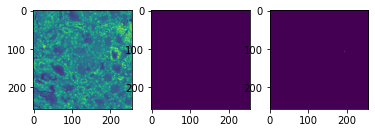

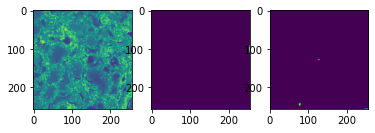

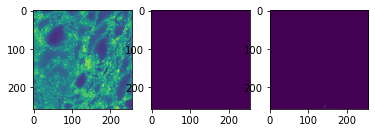

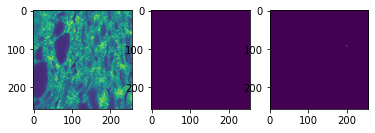

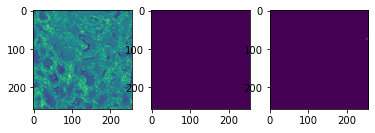

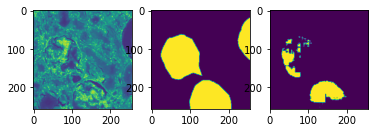

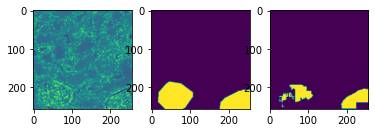

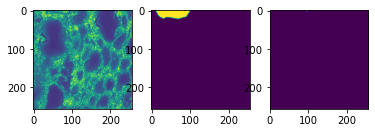

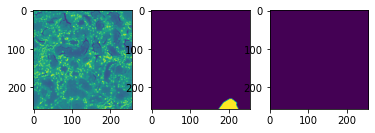

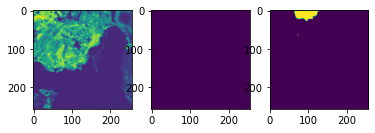

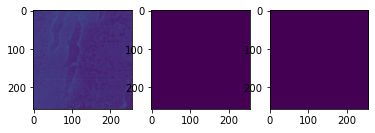

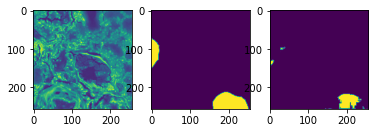

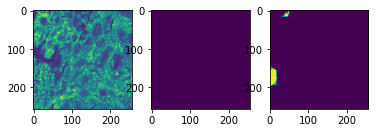

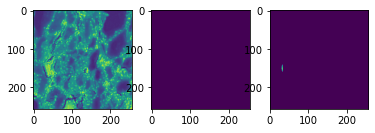

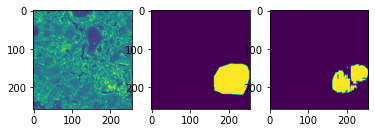

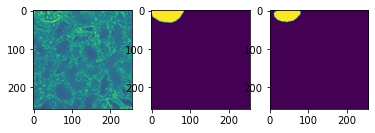

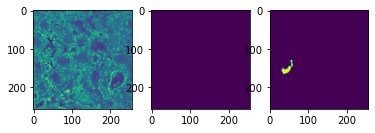

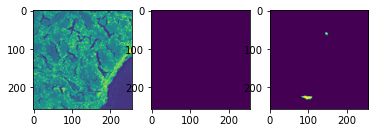

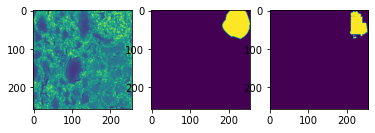

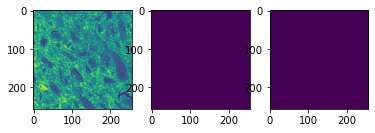

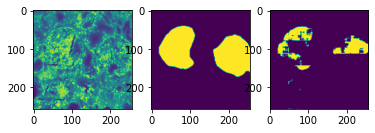

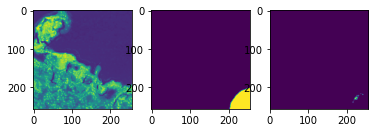

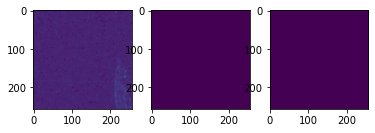

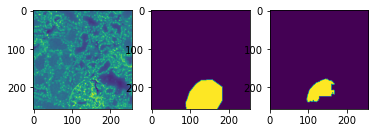

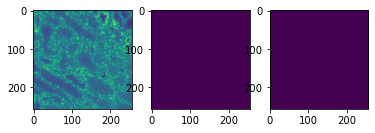

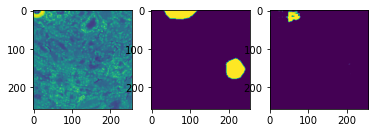

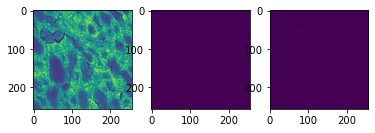

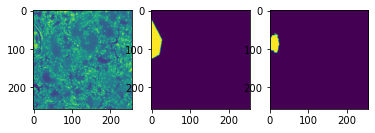

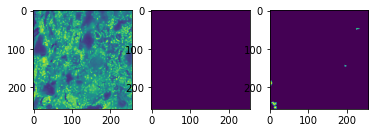

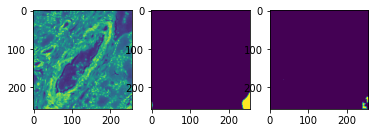

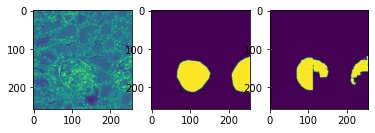

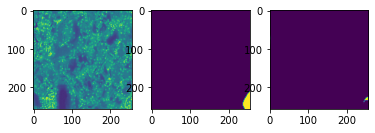

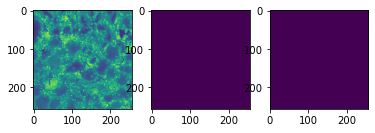

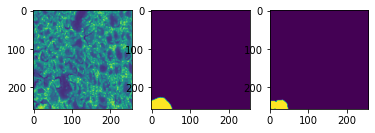

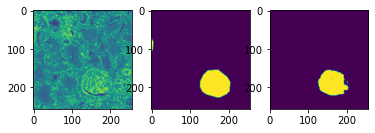

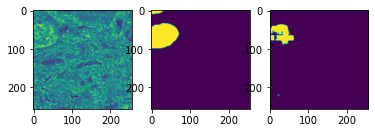

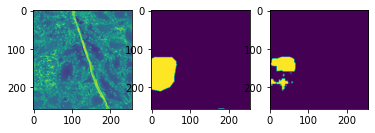

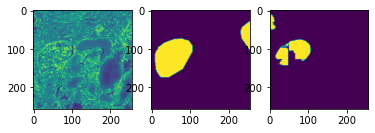

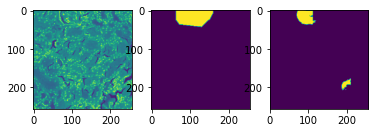

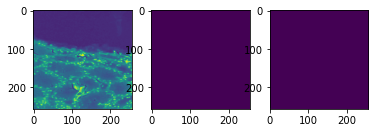

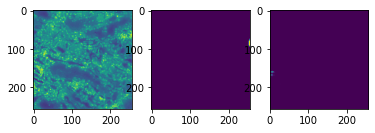

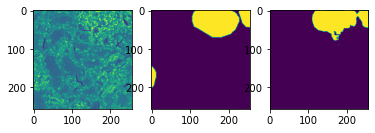

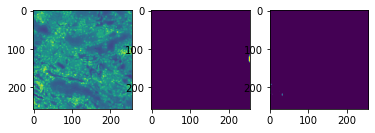

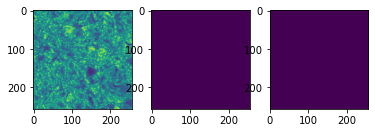

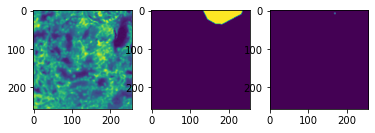

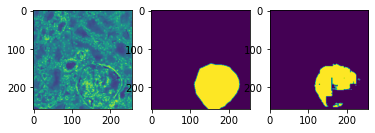

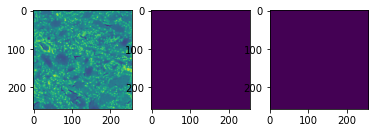

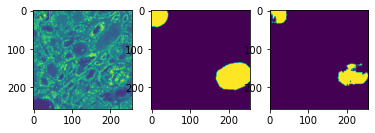

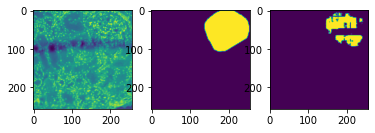

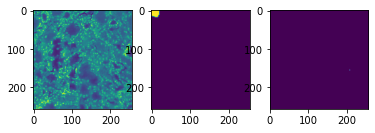

In [45]:
for b in train.take(1):
    
    masks = b[1]
    images = b[0]
    count = 0
    for image, mask in zip(images, masks):
        
        pred_mask = generator.predict(np.array([image]))[0]
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.subplot(1,3,3)
        plt.imshow(pred_mask)
        plt.show()
        count += 1
        if count == 50:
            break

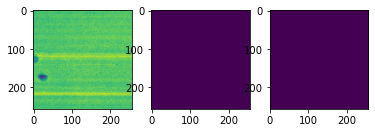

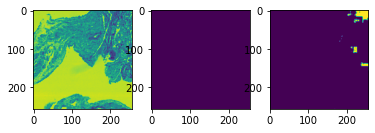

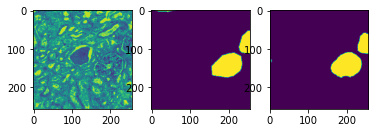

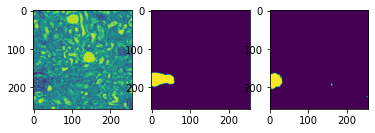

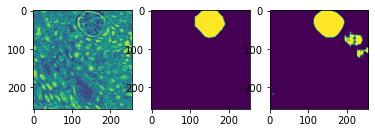

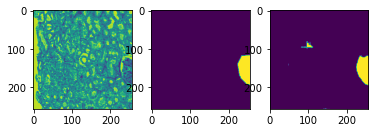

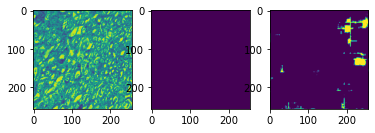

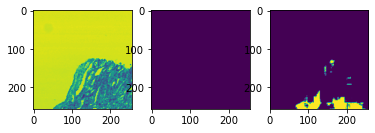

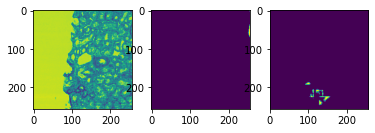

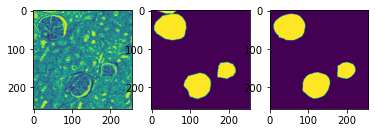

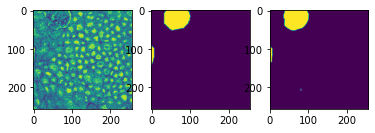

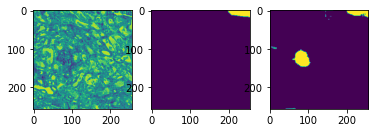

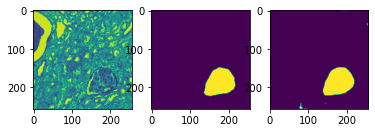

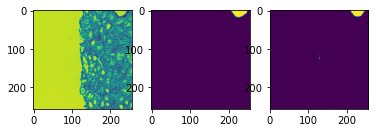

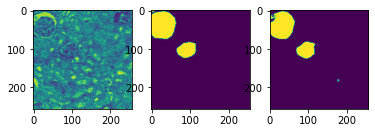

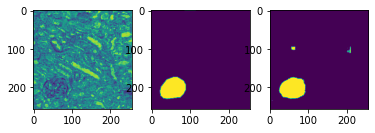

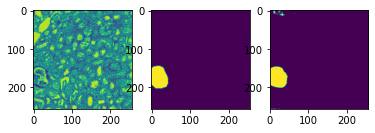

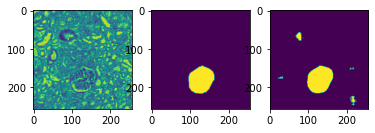

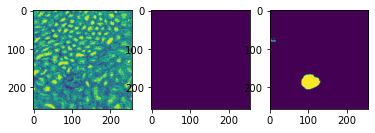

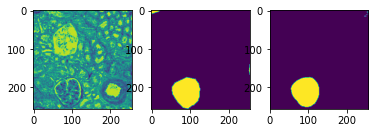

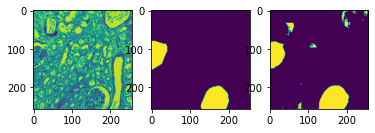

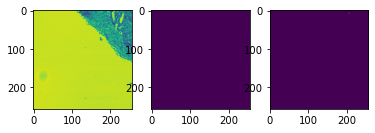

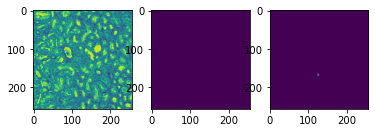

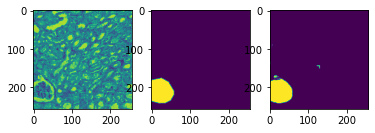

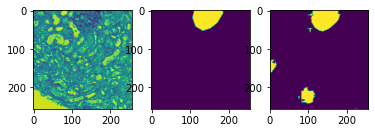

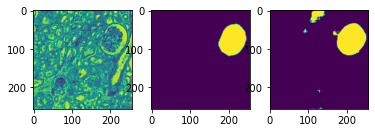

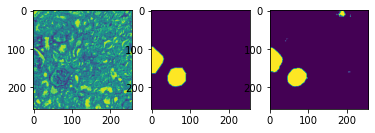

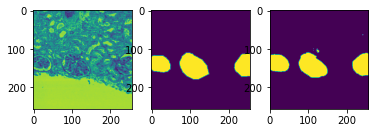

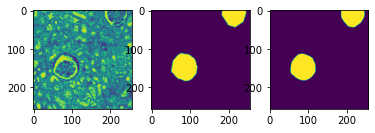

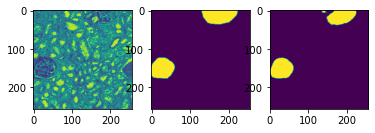

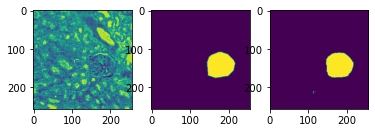

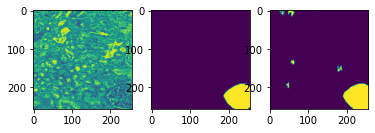

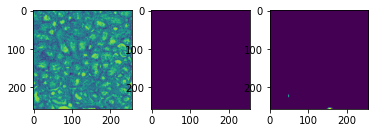

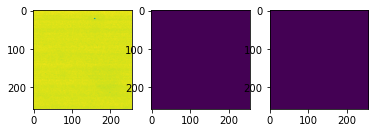

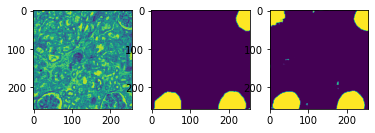

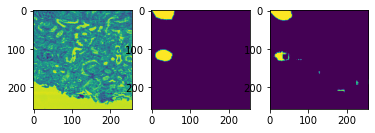

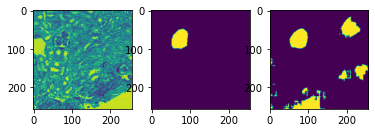

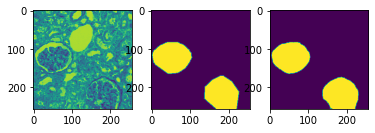

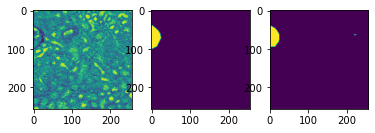

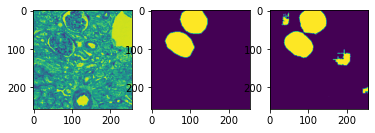

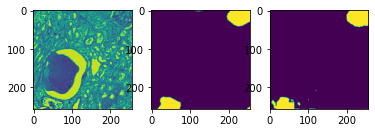

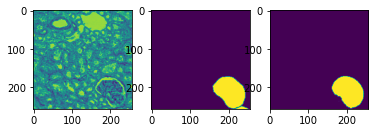

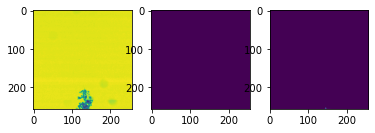

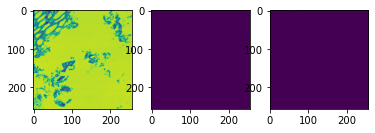

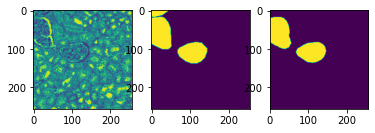

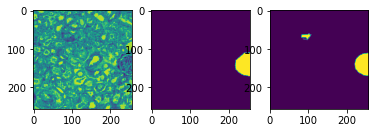

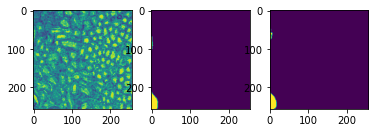

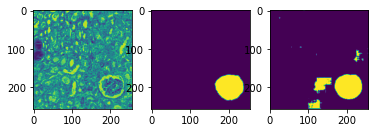

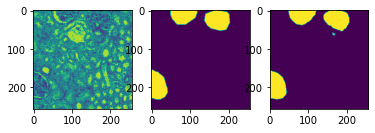

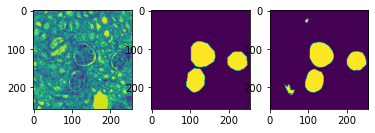

In [46]:
for b in test.take(1):
    
    masks = b[1]
    images = b[0]
    count = 0
    for image, mask in zip(images, masks):
        
        pred_mask = generator.predict(np.array([image]))[0]
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.subplot(1,3,3)
        plt.imshow(pred_mask)
        plt.show()
        count += 1
        if count == 50:
            break

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  generator=generator)

In [ ]:
# @tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape:
        
        gen_output = generator(input_image, training=True)

#         gen_total_loss = generator_loss(gen_output, target)

        gen_output = tf.reshape(gen_output, (256,256))
        gen_total_loss = dice_coef(gen_output, target)
        

#     generate_images(input_image, target, gen_output)

#     tf.print(gen_total_loss)


    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)


    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))

#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)

In [ ]:
np.newaxis

In [ ]:
input_image.shape

In [ ]:
def fit(epochs):

    for epoch in range(epochs):
        start = time.time()

        clear_output(wait=True)

#         clear_output(wait=True)

#         if (step + 1) % 5 == 0:
#             generate_images()

        print("Epoch: ", epoch)

        # Train
#         input_image, target = get_input_target()

        for n, raw_example in dataset.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            target, input_image = get_image_from_example(raw_example)

            train_step(input_image, target, epoch)

        print()

#         # saving (checkpoint) the model every 20 epochs
#         if (epoch + 1) % 20 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time taken for step {} is {} sec\n'.format(
            step + 1, time.time()-start))
#     checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 100

fit(EPOCHS)

In [ ]:
for n, raw_example in dataset.enumerate():
    target, input_image = get_image_from_example(raw_example)
    
    generate_images(input_image, target)
    
    input()
    clear_output(wait=False)

In [ ]:
generator.fit()